<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/llms-fine-tuning-notebooks/12_grpo_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Online RL(Group Relative Policy Optimization)

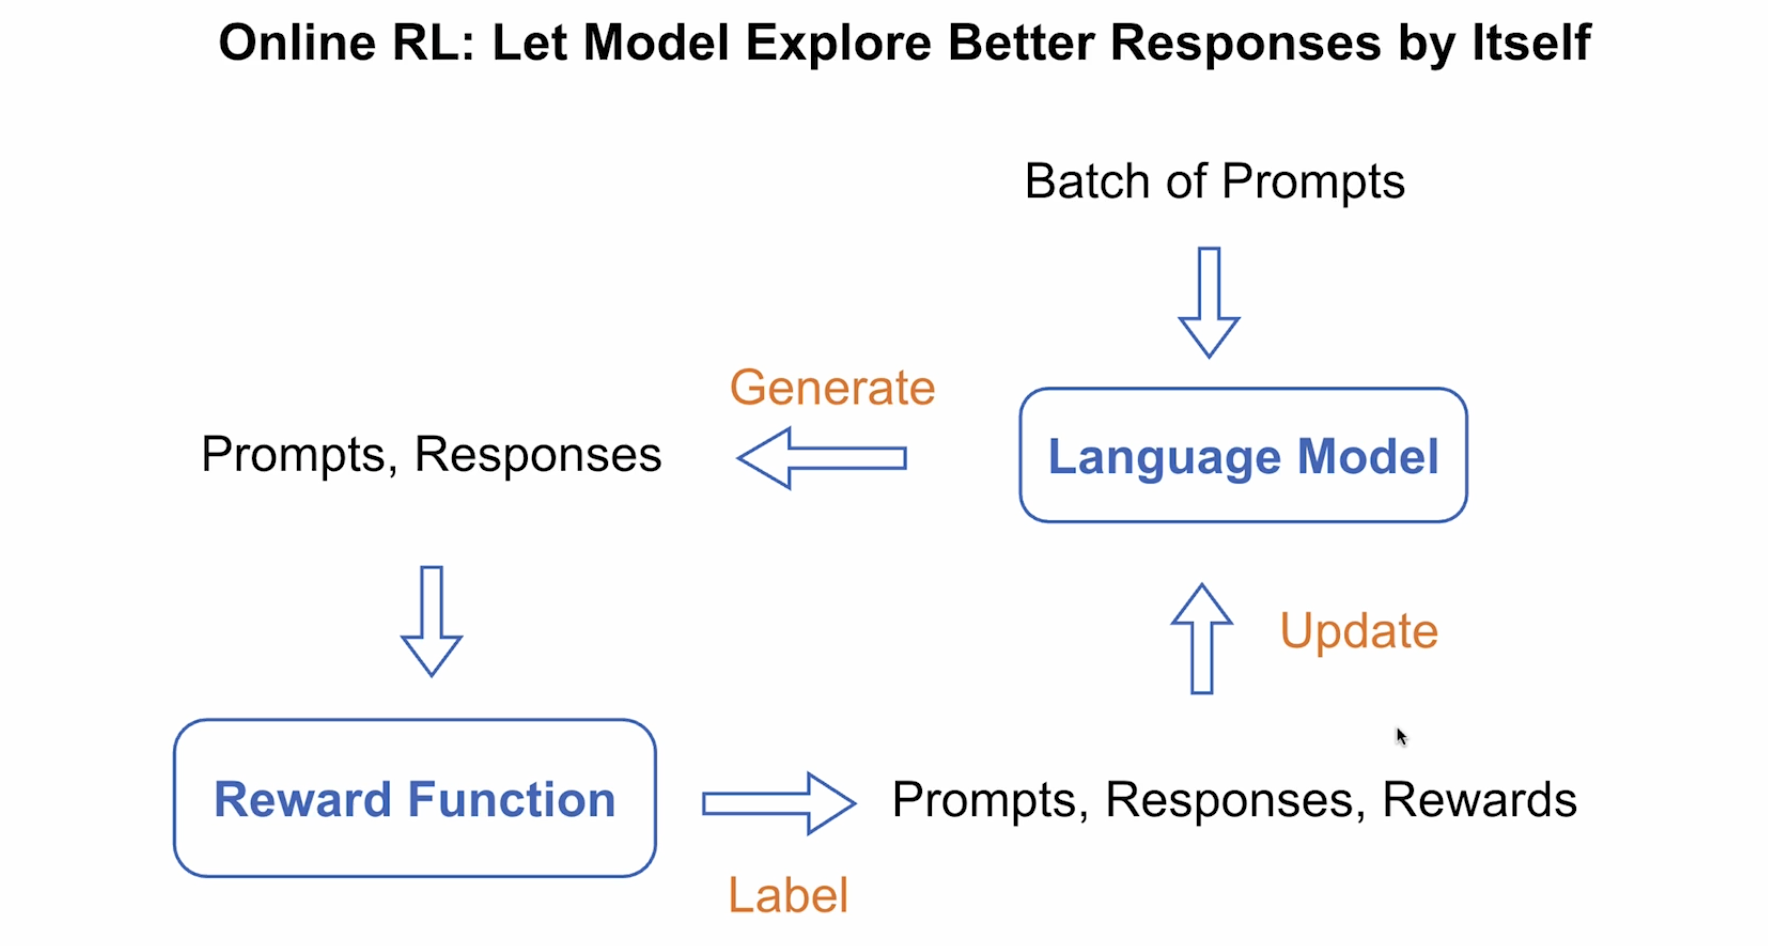

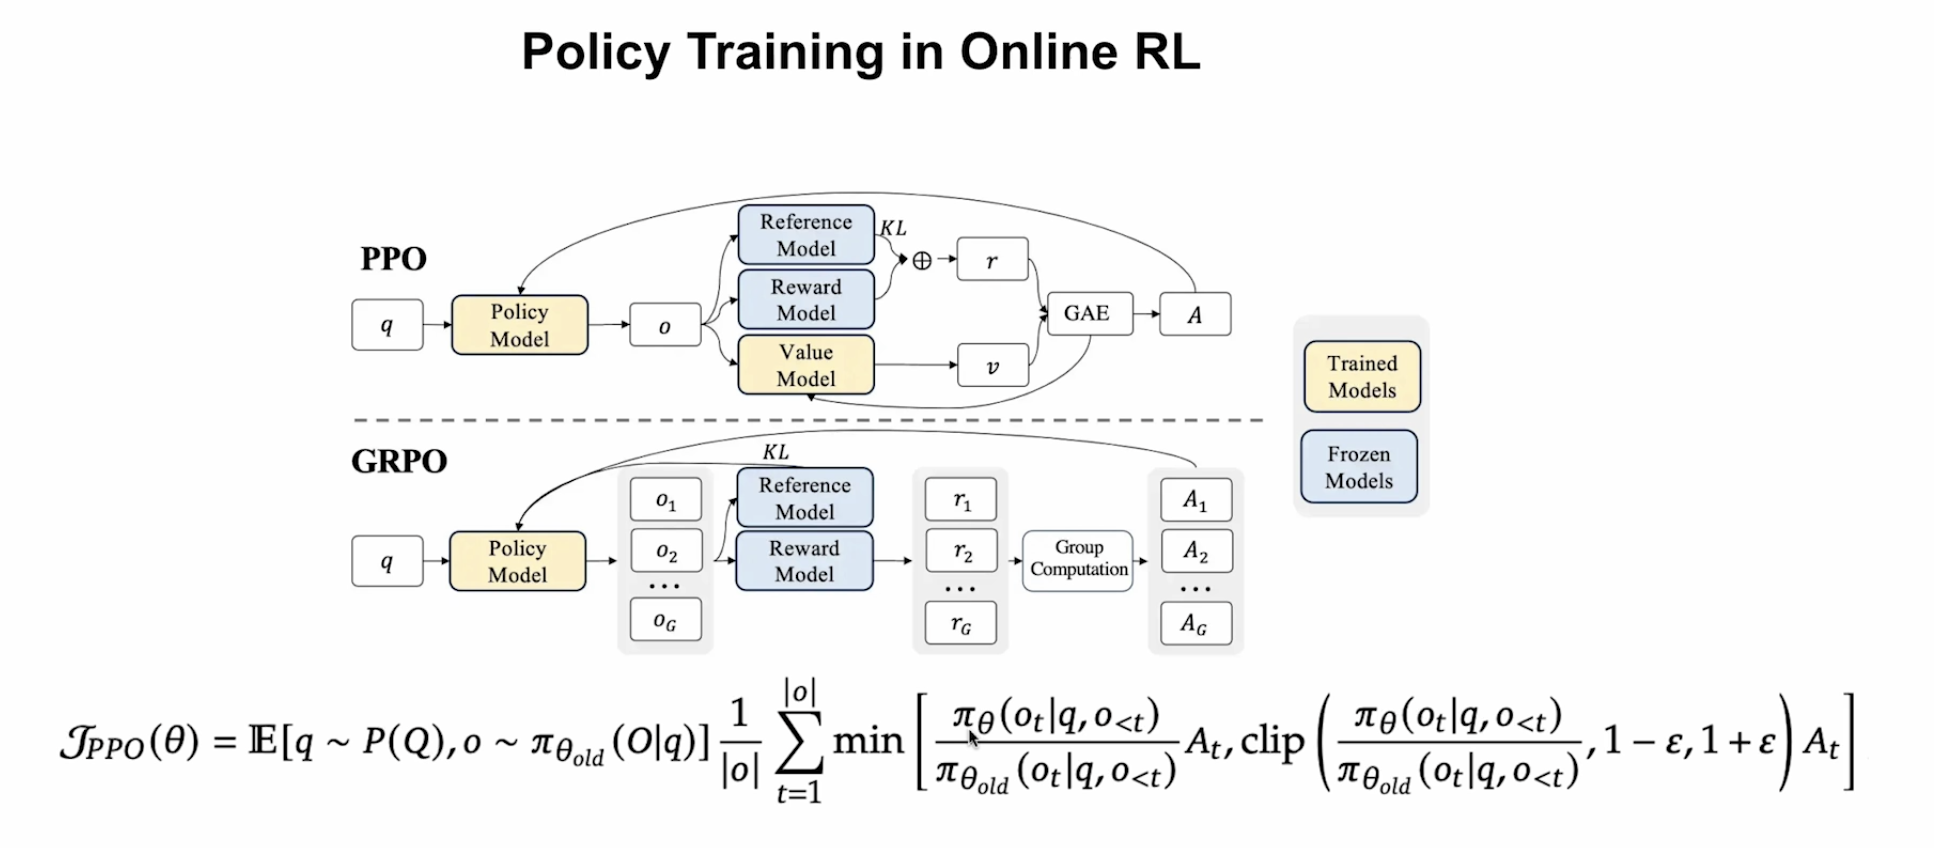

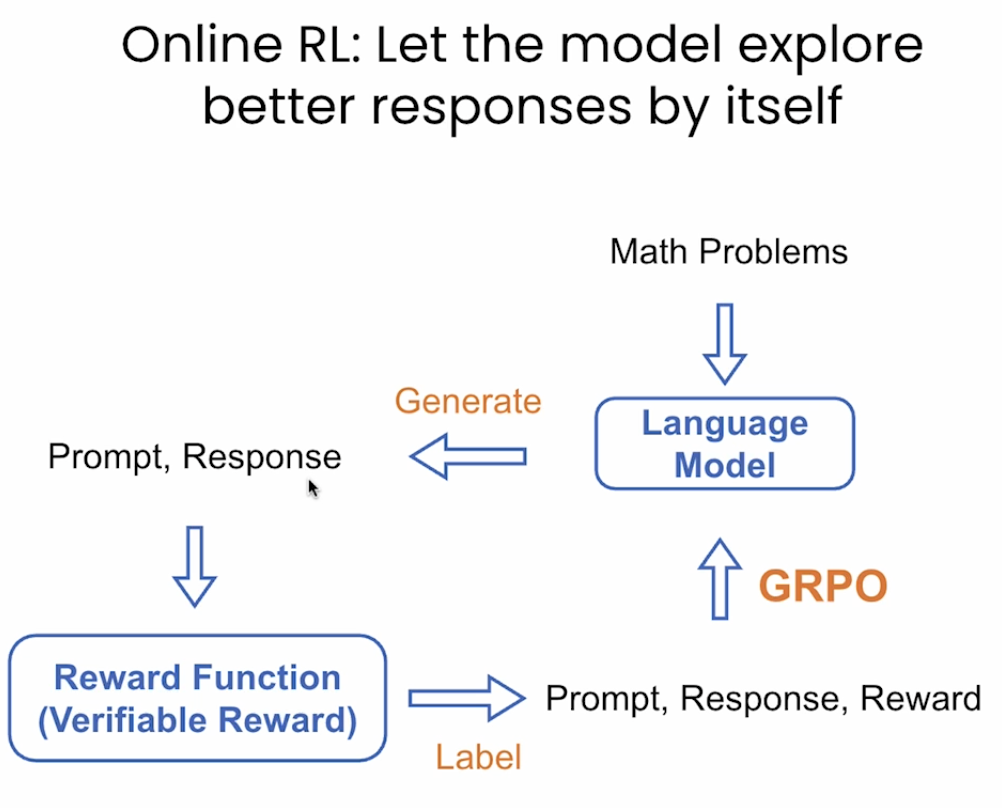

In [ ]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

## Import libraries

In [ ]:
import torch
from transformers import TrainingArguments, AutoTokenizer, AutoModelForCausalLM
from trl import GRPOTrainer, GRPOConfig
from datasets import load_dataset, Dataset
from helper import generate_responses, test_model_with_questions, load_model_and_tokenizer
import re
import pandas as pd
from tqdm import tqdm

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.</p>

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>
</div>

## Prepare for evaluation dataset for Math: GSM8K

In [ ]:
USE_GPU = False

SYSTEM_PROMPT = (
    "You are a helpful assistant that solves problems step-by-step. "
    "Always include the final numeric answer inside \\boxed{}."
)

In [ ]:
def reward_func(completions, ground_truth, **kwargs):
    # Regular expression to capture content inside \boxed{}
    matches = [re.search(r"\\boxed\{(.*?)\}", completion[0]['content']) for completion in completions]
    contents = [match.group(1) if match else "" for match in matches]
    # Reward 1 if the content is the same as the ground truth, 0 otherwise
    return [1.0 if c == gt else 0.0 for c, gt in zip(contents, ground_truth)]

In [ ]:
sample_pred = [[{"role": "assistant",
                 "content": r"...Calculating the answer. \boxed{72}"}]]
ground_truth = ["72"]
reward = reward_func(sample_pred, ground_truth)
print(f"Positive Sample Reward: {reward}")

Positive Sample Reward: [1.0]


In [ ]:
sample_pred = [[{"role": "assistant",
                 "content": r"...Calculating the answer \boxed{71}"}]]
ground_truth = ["72"]
reward = reward_func(sample_pred, ground_truth)
print(f"Negative Sample Reward: {reward}")

Negative Sample Reward: [0.0]


## Load the Evaluation Dataset

In [ ]:
data_num = 5
eval_dataset = load_dataset("openai/gsm8k", "main")["test"].select(range(data_num))
sample_df = eval_dataset.to_pandas()
display(sample_df)

README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

,question,answer
0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...
1,A robe takes 2 bolts of blue fiber and half th...,It takes 2/2=<<2/2=1>>1 bolt of white fiber\nS...
2,Josh decides to try flipping a house. He buys...,The cost of the house and repairs came out to ...
3,James decides to run 3 sprints 3 times a week....,He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*...
4,"Every day, Wendi feeds each of her chickens th...","If each chicken eats 3 cups of feed per day, t..."


In [ ]:
def post_processing(example):
    match = re.search(r"####\s*(-?\d+)", example["answer"])
    example["ground_truth"] = match.group(1) if match else None
    example["prompt"] = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": example["question"]}
    ]
    return example
eval_dataset = eval_dataset.map(post_processing).remove_columns(["question", "answer"])


Map:   0%|          | 0/5 [00:00<?, ? examples/s]

In [ ]:
sample_df = eval_dataset.select(range(5)).to_pandas()
display(sample_df)

,ground_truth,prompt
0,18,[{'content': 'You are a helpful assistant that...
1,3,[{'content': 'You are a helpful assistant that...
2,70000,[{'content': 'You are a helpful assistant that...
3,540,[{'content': 'You are a helpful assistant that...
4,20,[{'content': 'You are a helpful assistant that...


## Load the model and evaluate

In [ ]:
model, tokenizer = load_model_and_tokenizer("./models/Qwen/Qwen2.5-0.5B-Instruct", USE_GPU)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [ ]:
# Store predictions and ground truths
all_preds = []
all_labels = []

for example in tqdm(eval_dataset):
    input_prompt = example["prompt"]
    ground_truth = example["ground_truth"]
    # Run the model to generate an answer
    with torch.no_grad():
        response = generate_responses(model, tokenizer,
                                      full_message = input_prompt)
    all_preds.append([{"role": "assistant", "content": response}])
    all_labels.append(ground_truth)
    print(response)
    print("Ground truth: ", ground_truth)

# 3. Evaluate using reward_func
rewards = reward_func(all_preds, all_labels)

# 4. Report accuracy
accuracy = sum(rewards) / len(rewards)
print(f"Evaluation Accuracy: {accuracy:.2%}")
del model, tokenizer

 20%|██        | 1/5 [00:14<00:59, 14.98s/it]

To determine how much Janet makes at the farmers' market each day, we need to follow these steps:

1. Calculate the total number of eggs laid by the ducks in one day.
2. Determine how many eggs are eaten in one day.
3. Subtract the number of eggs eaten from the total number of eggs to find out how many eggs are sold.
4. Calculate the revenue from selling the eggs.

Let's start with the first step:

1. The ducks lay 16 eggs per day.
2. Janet eats 3 eggs for breakfast every morning, so the number of eggs eaten in one day is:
   \[
   16 - 3 = 13
   \]
3. Janet bakes muffins for her friends every day, which means she bakes 4 muffins. So, the number of eggs baked in one day is:
   \[
   13 + 4 = 17
   \]
4. Janet sells the remaining eggs at the farmers' market. Since there are 16 eggs in total and 17 eggs are sold, the number of eggs left to sell is:
   \[
   16 - 17 = -1
   \]
   However, since it's not possible to sell fewer than 0 eggs, this indicates that Janet has no eggs left to sell

 40%|████      | 2/5 [00:25<00:36, 12.13s/it]

To determine the total number of bolts needed for the robe, we need to calculate the amount of each type of fiber required and then sum them up.

1. **Blue Fiber:**
   - The problem states that it takes 2 bolts of blue fiber.
   - Therefore, the number of bolts of blue fiber is \(2\).

2. **White Fiber:**
   - It takes half as much white fiber as blue fiber.
   - Since 2 bolts of blue fiber require 2 bolts of white fiber, the number of bolts of white fiber is:
     \[
     \frac{2}{2} = 1
     \]

3. **Total Number of Bolts:**
   - To find the total number of bolts needed, we add the number of bolts of blue fiber and the number of bolts of white fiber:
     \[
     2 + 1 = 3
     \]

Thus, the total number of bolts required for the robe is \(\boxed{3}\).
Ground truth:  3


 60%|██████    | 3/5 [00:40<00:26, 13.40s/it]

To determine Josh's profit from flipping his house, we need to follow these steps:

1. **Calculate the total cost of the house:**
   - The house costs $80,000.
   - Josh also spends an additional $50,000 on repairs.

2. **Determine the net cost after repairs:**
   - Net cost = Total cost - Cost of repairs
   - Net cost = $80,000 - $50,000 = $30,000

3. **Calculate the increase in value due to repairs:**
   - The value of the house increased by 150%.
   - Increase in value = Percentage increase × Original value
   - Increase in value = 150% × $80,000
   - Increase in value = 1.5 × $80,000 = $120,000

4. **Determine the new value of the house:**
   - New value = Original value + Increase in value
   - New value = $80,000 + $120,000 = $200,000

5. **Calculate the profit:**
   - Profit = New value - Net cost
   - Profit = $200,000 - $30,000 = $170,
Ground truth:  70000


 80%|████████  | 4/5 [00:49<00:11, 11.68s/it]

To determine how many total meters James runs in a week, we need to follow these steps:

1. Calculate the distance James runs in one sprint.
2. Multiply the distance of one sprint by the number of sprints he runs per week.

First, let's find out how far James runs in one sprint:
\[ \text{Distance per sprint} = 60 \text{ meters} \]

Next, since James runs 3 sprints per week, we multiply the distance of one sprint by 3:
\[ \text{Total distance per week} = 60 \text{ meters/sprint} \times 3 \text{ sprints/week} \]
\[ \text{Total distance per week} = 180 \text{ meters} \]

So, the total distance James runs in a week is:
\[
\boxed{180}
\]
Ground truth:  540


100%|██████████| 5/5 [01:04<00:00, 12.82s/it]

To determine how many cups of feed Wendi needs for the final meal of the day, we can follow these steps:

1. Calculate the total amount of feed needed for all the chickens.
2. Determine how much feed is given away in the morning and the afternoon.
3. Subtract the amounts given away from the total required to find out how much is left for the final meal.

First, let's calculate the total amount of feed needed for all the chickens:
- Each chicken gets 3 cups of feed per day.
- There are 20 chickens in total.

So, the total amount of feed needed is:
\[ 20 \text{ chickens} \times 3 \text{ cups/chicken} = 60 \text{ cups} \]

Next, we calculate the amount of feed given away in the morning and the afternoon:
- In the morning: \( 15 \text{ cups} \)
- In the afternoon: \( 25 \text{ cups} \)

Now, we subtract the amounts given away from the total required:
\[ 60 \text{ cups} - (15 \text{ cups} + 25 \text{ cups}) = 60 \text{ cups} - 40 \text{ cups} = 20 \text{ cups} \]

Therefore, the number of c

## Loading the training dataset

In [ ]:
dataset = load_dataset("openai/gsm8k", "main")
train_dataset = dataset["train"]

# Apply to dataset
train_dataset = train_dataset.map(post_processing)
train_dataset = train_dataset.remove_columns(["question", "answer"])
if not USE_GPU:
    train_dataset = train_dataset.select(range(10))
print(train_dataset[0])

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

{'ground_truth': '72', 'prompt': [{'content': 'You are a helpful assistant that solves problems step-by-step. Always include the final numeric answer inside \\boxed{}.', 'role': 'system'}, {'content': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?', 'role': 'user'}]}


## GRPO Training

In [ ]:
config = GRPOConfig(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    num_generations=4, # Can set as high as 64 or 128
    num_train_epochs=1,
    learning_rate=5e-6,
    logging_steps=2,
    no_cuda= not USE_GPU     # keeps the whole run on CPU, incl. MPS
)

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Note:</b> We're performing GROP on a small model <code>HuggingFaceTB/SmolLM2-135M-Instruct</code> and a smaller training dataset to to ensure the full training process can run on limited computational resources. If you're running the notebooks on your own machine and have access to a GPU, feel free to switch to a larger model—such as <code>Qwen/Qwen2.5-0.5B-Instruct</code>—to perform full GRPO and reproduce the results shown above.</p>
</div>

In [ ]:
## If this block hangs or the kernel restarts during training, please skip loading the previous 0.5B model for evaluation

model, tokenizer = load_model_and_tokenizer("./models/HuggingFaceTB/SmolLM2-135M-Instruct", USE_GPU)

grpo_trainer = GRPOTrainer(
    model=model,
    args=config,
    reward_funcs=reward_func,
    train_dataset=train_dataset
)

grpo_trainer.train()

Step,Training Loss


TrainOutput(global_step=1, training_loss=0.0, metrics={'train_runtime': 103.9073, 'train_samples_per_second': 0.096, 'train_steps_per_second': 0.01, 'total_flos': 0.0, 'train_loss': 0.0})

## Results of the fully trained Qwen model

<hr>

**Note:** Due to limited computational resources, we used a small model and dataset for GRPO training. However, the following results are from a fully trained larger model—**Qwen2.5-0.5B**—to demonstrate the complete outcome of the GRPO process. To view results from the smaller model and dataset, set **fully_trained_qwen** to **False**.

In [ ]:
fully_trained_qwen = True
if fully_trained_qwen:
    model, tokenizer = load_model_and_tokenizer("./models/banghua/Qwen2.5-0.5B-GRPO",
                                            USE_GPU)
else:
    model = grpo_trainer.model

# Store predictions and ground truths
all_preds = []
all_labels = []

for example in tqdm(eval_dataset):
    input_prompt = example["prompt"]
    ground_truth = example["ground_truth"]
    # Run the model to generate an answer
    with torch.no_grad():
        response = generate_responses(model, tokenizer,
                                      full_message = input_prompt)
    all_preds.append([{"role": "assistant", "content": response}])
    all_labels.append(ground_truth)
    print(response)
    print("Ground truth: ", ground_truth)

# 3. Evaluate using reward_func
rewards = reward_func(all_preds, all_labels)

# 4. Report accuracy
accuracy = sum(rewards) / len(rewards)
print(f"Evaluation Accuracy: {accuracy:.2%}")